# ING Hubs Hackaton

29.01.2021

Jaime Elguero, Santiago Gil, Borja Serra

# Open AIGym

[Gym](https://gym.openai.com/) is a toolkit for developing and comparing reinforcement learning algorithms. It makes no assumptions about the structure of your agent, and is compatible with any numerical computation library, such as TensorFlow or Theano.

The gym library is a collection of test problems — environments — that you can use to work out your reinforcement learning algorithms. These environments have a shared interface, allowing you to write general algorithms.

[Environments](https://gym.openai.com/envs/#classic_control) 

In [8]:
import gym

import pandas as dp
import numpy as np
import matplotlib.pyplot as plt

There is a lot of nice environments to work with:

### Mountain Car environment

For this Hackaton, we will Focus on the **MountainCar** one. Still if your team finished before time, feel free to explore any other environment you may like

In [114]:
# Import and initialize Mountain Car Environment
env = gym.make('MountainCar-v0')
#env.reset()
#env.seed(1); np.random.seed(1)

**Mountain Car** is a classic reinforcement learning problem where the objective is to create an algorithm that learns to climb a steep hill to reach the goal marked by a flag. The car’s engine is not powerful enough to drive up the hill without a head start so the car must drive up the left hill to obtain enough momentum to scale the steeper hill to the right and reach the goal.

In [11]:
from IPython.display import Video

Video("mountain_car.mp4")

Here we have more detailed information about it, especially focused to inputing a RL algorithm (actions, reward, etc.)

In [115]:
print(gym.envs.classic_control.mountain_car.MountainCarEnv.__doc__)


    Description:
        The agent (a car) is started at the bottom of a valley. For any given
        state the agent may choose to accelerate to the left, right or cease
        any acceleration.

    Source:
        The environment appeared first in Andrew Moore's PhD Thesis (1990).

    Observation:
        Type: Box(2)
        Num    Observation               Min            Max
        0      Car Position              -1.2           0.6
        1      Car Velocity              -0.07          0.07

    Actions:
        Type: Discrete(3)
        Num    Action
        0      Accelerate to the Left
        1      Don't accelerate
        2      Accelerate to the Right

        Note: This does not affect the amount of velocity affected by the
        gravitational pull acting on the car.

    Reward:
         Reward of 0 is awarded if the agent reached the flag (position = 0.5)
         on top of the mountain.
         Reward of -1 is awarded if the position of the agent is less than 

### A random agent to interact with the environment

- The state of the environment is the tuple **(position, velocity)**. As an starting point we will start with a null velocity and somewhere around the center of the valley (what is randomly aprox. -0.5)

In [116]:
state = env.reset()
print (state)

[-0.52034002  0.        ]


- The boundaries of our observation space are the follows:

In [117]:
env.observation_space.high

array([0.6 , 0.07], dtype=float32)

In [118]:
env.observation_space.low

array([-1.2 , -0.07], dtype=float32)

- And we also have the information of the possible actions we can perform, in this environment only 3 (see doc above):

In [119]:
env.action_space

Discrete(3)

- With all this, we have the enough information to navigate through the environment:

In [121]:
env.reset();

for i in range(200):
    # We can visually render the current observation
    env.render()
    # We select a random action
    action = np.random.randint(0, env.action_space.n)
    # We apply the action, and receive information from the environment
    state, reward, done, info = env.step(action)
    
# We close the environment
env.close()

- A typical RL algorithm will make use of episodes as follows:

In [305]:
# Initialize variables to track rewards
reward_list = [] # Temporal one
ave_reward_list = []
successful = []
last_position_episodes = []

EPISODES = 10000

# Run RL algorithm
for i in range(EPISODES):
    
    # Initialize parameters
    done = False
    tot_reward, reward = 0,0
    state = env.reset()

    position, velocity = state

    # Done will be True when:
    #  1. 200 iterations have happened OR
    #  2. The car reached the flag
    
    while done != True:

        # %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
        # NEMANJA'S SOLUTION
        # %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
        
        going_left = velocity < 0

        if going_left:
            action = 0
        else:
            action = 2

        # %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

        state, reward, done, info = env.step(action)

        position, velocity = state

        tot_reward += reward

        if done:
            break
    
    # We track the last position on the episode
    last_position_episodes.append(state[0])
    
    # The done condition was triggered because the car reached the flag
    if state[0] >= 0.5:
        successful.append(i)
        
    # Track rewards
    reward_list.append(tot_reward)
    
    # Show average rewards per 100 episodes
    if (i+1) % 100 == 0:
        ave_reward = np.mean(reward_list)
        ave_reward_list.append(ave_reward)
        reward_list = []
        print('Episode {} Average Reward: {}'.format(i+1, ave_reward))
        
env.close()

Episode 100 Average Reward: -119.71
Episode 200 Average Reward: -119.86
Episode 300 Average Reward: -119.03
Episode 400 Average Reward: -119.17
Episode 500 Average Reward: -119.3
Episode 600 Average Reward: -119.29
Episode 700 Average Reward: -118.86
Episode 800 Average Reward: -119.66
Episode 900 Average Reward: -119.49
Episode 1000 Average Reward: -119.64
Episode 1100 Average Reward: -119.54
Episode 1200 Average Reward: -119.89
Episode 1300 Average Reward: -119.44
Episode 1400 Average Reward: -119.31
Episode 1500 Average Reward: -120.01
Episode 1600 Average Reward: -118.6
Episode 1700 Average Reward: -119.48
Episode 1800 Average Reward: -118.89
Episode 1900 Average Reward: -119.22
Episode 2000 Average Reward: -119.58
Episode 2100 Average Reward: -118.74
Episode 2200 Average Reward: -119.35
Episode 2300 Average Reward: -119.31
Episode 2400 Average Reward: -118.83
Episode 2500 Average Reward: -119.45
Episode 2600 Average Reward: -119.62
Episode 2700 Average Reward: -119.89
Episode 2800

- We offer you some plot functions to monitor how the RL algorithm is learning

In this case, since it is a random agent, we can see that we are not learning anything at all

In [306]:
def plot_last_positions(positions):
    plt.figure(2, figsize=[10,5])
    p = pd.Series(positions)
    ma = p.rolling(10).mean()
    plt.plot(p, alpha=0.8)
    plt.plot(ma)
    plt.xlabel('Episode')
    plt.ylabel('Position')
    plt.title('Car Final Position')
    plt.show()

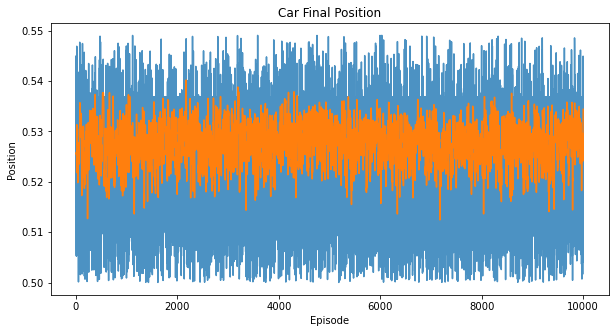

In [307]:
plot_last_positions(last_position_episodes)

In [308]:
def plot_rewards(ave_reward_list):
    plt.subplots(figsize=(10,5))
    plt.plot(100*(np.arange(len(ave_reward_list)) + 1), ave_reward_list)
    plt.xlabel('Episodes')
    plt.ylabel('Average Reward')
    plt.title('Average Reward vs Episodes');

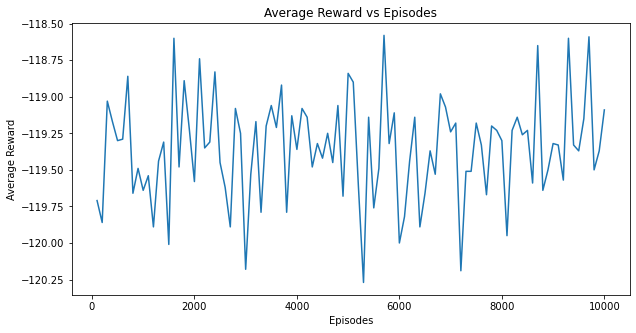

In [309]:
plot_rewards(ave_reward_list)

In [310]:
def plot_successes(successful):
    fig, ax = plt.subplots(figsize=(10,5))
    ax.hist(successful, bins = int(EPISODES/500));
    ax.set_xlabel('Episodes');
    ax.set_ylabel('#Successful');
    print('successful episodes: {}'.format(np.count_nonzero(successful)))

successful episodes: 9999


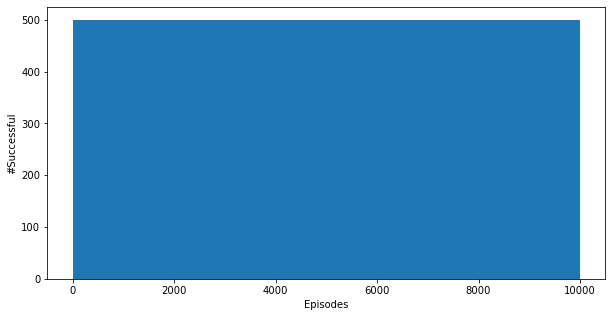

In [311]:
plot_successes(successful)

# Can you make it better?

- The collection of some produced variables are sent to us, and we will give you a SCORE

In [312]:
import hackathon_mad_hub_2101 as hack_tools

In [313]:
team = "Mercedes"

hack_tools.post_score(team, [ave_reward_list, successful, last_position_episodes])

"Score posted!"



[Leaderboard](https://hackathon-ing-mad-hub-2101.herokuapp.com/)
